In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
!pip install -q tensorflow_hub
!pip install pydot graphviz
!pip install pydot3 pydot-ng

In [0]:
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot
inception_model = InceptionV3(weights='imagenet', include_top=False)
#SVG(model_to_dot(inception_model).create(prog='dot', format='svg'))

In [0]:
# check the layers by name
for i,layer in enumerate(inception_model.layers):
    print(i,layer.name)


In [21]:
from keras.preprocessing.image import ImageDataGenerator
# data_train= '/content/drive/My Drive/maps/train'
# data_test = '/content/drive/My Drive/maps/test'

data_train= '/content/drive/My Drive/maps4000/train'
data_test = '/content/drive/My Drive/maps4000/test'



image_size=299

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 200
val_batchsize = 50
 
train_generator = train_datagen.flow_from_directory(
        str(data_train),
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

for image_batch,label_batch in train_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3210 images belonging to 4 classes.
Image batch shape:  (200, 299, 299, 3)
Labe batch shape:  (200, 4)


In [22]:
test_generator = validation_datagen.flow_from_directory(
        str(data_test),
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
for image_batch,label_batch in test_generator :
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 809 images belonging to 4 classes.
Image batch shape:  (50, 299, 299, 3)
Labe batch shape:  (50, 4)


In [0]:
#fine tune method 1

#Load the Inception-V3 model
from keras.applications.inception_v3 import InceptionV3

image_size = 299
Inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers except the last 40 layers
for layer in Inception_v3.layers[:-40]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
# for layer in Inception_v3.layers:
#     print(layer, layer.trainable)

from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(Inception_v3)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

In [32]:
#fine tune method 2
import random
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
import numpy as np

inc_model = InceptionV3(weights='imagenet', include_top=False)

# get layers and add average pooling layer
x = inc_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
x = Dense(512, activation='relu')(x)

# add output layer
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=inc_model.input, outputs=predictions)



# choose the layers which are updated by training
# layer_num = len(model.layers)
# for layer in model.layers[:279]:
#     layer.trainable = False

# for layer in model.layers[279:]:
#     layer.trainable = True

for layer in model.layers[:-4]:
    layer.trainable = False
    
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_659 (Conv2D)             (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_659 (BatchN (None, None, None, 3 96          conv2d_659[0][0]                 
__________________________________________________________________________________________________
activation_659 (Activation)     (None, None, None, 3 0           batch_normalization_659[0][0]    
__________________________________________________________________________________________________
conv2d_660

In [24]:
from keras import models
from keras import layers
from keras import optimizers

# training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
#Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=10,
      validation_data=test_generator,
      validation_steps=test_generator.samples//test_generator.batch_size,
      verbose=1)

Epoch 1/16
16/16 [==============================] - 793s 50s/step - loss: 0.4996 - acc: 0.8457 - val_loss: 0.8580 - val_acc: 0.6166
Epoch 2/16
16/16 [==============================] - 127s 8s/step - loss: 0.1107 - acc: 0.9741 - val_loss: 0.7766 - val_acc: 0.6738
Epoch 3/16
16/16 [==============================] - 155s 10s/step - loss: 0.0602 - acc: 0.9868 - val_loss: 0.6333 - val_acc: 0.7760
Epoch 4/16
16/16 [==============================] - 154s 10s/step - loss: 0.0422 - acc: 0.9918 - val_loss: 0.6065 - val_acc: 0.7826
Epoch 5/16
16/16 [==============================] - 154s 10s/step - loss: 0.0549 - acc: 0.9863 - val_loss: 0.6030 - val_acc: 0.7984
Epoch 6/16
16/16 [==============================] - 153s 10s/step - loss: 0.0265 - acc: 0.9934 - val_loss: 0.6375 - val_acc: 0.7628
Epoch 7/16
16/16 [==============================] - 153s 10s/step - loss: 0.0127 - acc: 0.9972 - val_loss: 0.5778 - val_acc: 0.7971
Epoch 8/16
16/16 [==============================] - 154s 10s/step - loss: 0.0

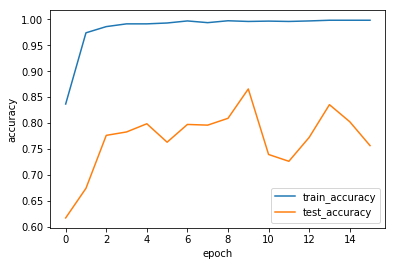

In [25]:
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

show_history(history)

In [30]:
res=model.evaluate_generator(test_generator, 
                              steps=1,
                              verbose=1)
res[1]

1/1 [==============================] - 2s 2s/step


0.7599999904632568